In [1]:
from sklearn.model_selection import train_test_split

from scripts.data_genertion.consts import *
from scripts.data_genertion.data_handling import populate_features, get_populate_fold
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

Loading features from: ['ASO_volume(nM).csv', 'Canonical Gene Name.csv', 'Cell line organism.csv', 'Cell_line.csv', 'Chemical_Pattern.csv', 'Density(cells_per_well).csv', 'ISIS.csv', 'Inhibition(%).csv', 'Linkage.csv', 'Linkage_Location.csv', 'Location.csv', 'Location_div_by_length.csv', 'Location_in_sequence.csv', 'Modification.csv', 'Primer_probe_set.csv', 'Sequence.csv', 'Target_gene.csv', 'Transcript.csv', 'Transfection.csv', 'Treatment_Period(hours).csv', 'at_rich_region_score.csv', 'at_skew.csv', 'cell_line_uniform.csv', 'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t3

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13', 'PRMT5', 'MAT2A', 'RIOK1']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df[[SENSE_TYPE, 'sense_intron', 'sense_exon', 'sense_utr', SENSE_START, CANONICAL_GENE]]

,sense_type,sense_intron,sense_exon,sense_utr,sense_start,Canonical Gene Name
0,intron,1,0,0,41212,KRAS
1,intron,1,0,0,23686,KRAS
2,intron,1,0,0,43363,KRAS
3,intron,1,0,0,23680,KRAS
4,intron,1,0,0,41168,KRAS
...,...,...,...,...,...,...
29982,intron,1,0,0,7827,APOL1
29983,intron,1,0,0,8250,APOL1
29984,intron,1,0,0,8335,APOL1
29985,utr,0,1,1,13848,APOL1


In [5]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [6]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            # if feature in [SENSE_TYPE]:
            #     self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
                           'poly_pyrimidine_stretch', 'normalized_start', 'sense_exon', 'sense_intron', 'sense_utr']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_volume(nM)', 'Canonical Gene Name', 'Cell line organism',
       'Cell_line', 'Chemical_Pattern', 'Density(cells_per_well)', 'ISIS',
       'Inhibition(%)', 'Linkage', 'Linkage_Location', 'Location',
       'Location_div_by_length', 'Location_in_sequence', 'Modification',
       'Primer_probe_set', 'Sequence', 'Target_gene', 'Transcript',
       'Transfection', 'Treatment_Period(hours)', 'at_rich_region_score',
       'at_skew', 'cell_line_uniform',
       'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600',

In [7]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [8]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [9]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.01
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [10]:
collapsed

,ISIS,ASO_volume(nM),Treatment_Period(hours),Density(cells_per_well),Chemical_Pattern,log_inhibition
0,76577.0,4000.0,48.0,10000.0,CCCddddddddddCCC,0.462035
1,146143.0,187.5,16.0,20000.0,MMMMMddddddddddMMMMM,0.051293
2,146143.0,750.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.116534
3,146143.0,3000.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.693147
4,146143.0,4000.0,24.0,20000.0,MMMMMddddddddddMMMMM,0.713350
...,...,...,...,...,...,...
23189,70001072.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.347074
23190,70001081.0,5000.0,96.0,2000.0,LLLLdddddddddLLLL,1.108663
23191,70001101.0,5000.0,96.0,15000.0,LLLddddddddddLLL,1.386294
23192,70001102.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.272966


In [11]:
import numpy as np


def log_inhibition_to_regular(log_inhibition):
    return 100 * (-np.exp(-log_inhibition) + log_correction)


In [12]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]
print(features_obj.one_hot)
for feature in features_obj.one_hot:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

one_hot_features = []
for one_hot_feature in features_obj.one_hot:
    one_hot_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
flat_one_hot_encoded_features = [feature for sublist in one_hot_features for feature in sublist]
# features = epi_features
features = epi_features + features + flat_one_hot_encoded_features


[]


In [13]:
filtered = filtered[filtered[CELL_LINE].isin(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'])]
filtered[CELL_LINE].unique()

array(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'],
      dtype=object)

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRanker

seed = 42

train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
# train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()

metric = 'correct_log_inhibition'
# metric = 'log_inhibition'
# metric = INHIBITION

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
# y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
y = train[metric]

model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed)
# model = XGBRanker(objective='rank:pairwise')
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)


Test:  2999
Train:  11996


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

cell-line:A431, length:6541  A431
correct_log_inhibition
gene-KRAS length: 925
P:0.073, p-value: 0.026
S:0.12 , p-value: 0.00025
gene-MALAT1 length: 3053
P:0.53, p-value: 1.3e-219
S:0.44 , p-value: 7.1e-142
gene-SOD1 length: 429
P:0.2, p-value: 4.7e-05
S:0.21 , p-value: 8.6e-06
gene-APOL1 length: 2134
P:0.29, p-value: 4.8e-43
S:0.25 , p-value: 1.5e-30
cell-line:KARPAS-229, length:972  KARPAS-229
correct_log_inhibition
gene-IRF5 length: 972
P:0.42, p-value: 1.8e-43
S:0.45 , p-value: 3.2e-50
cell-line:MM.1R, length:3394  MM.1R
correct_log_inhibition
gene-IRF4 length: 3394
P:0.46, p-value: 5.9e-177
S:0.45 , p-value: 1.7e-169
cell-line:SK-MEL-28, length:2836  SK-MEL-28
correct_log_inhibition
gene-IRF4 length: 2836
P:0.37, p-value: 7.6e-94
S:0.36 , p-value: 5.3e-90
cell-line:SNU-449, length:1119  SNU-449
correct_log_inhibition
gene-YAP1 length: 1119
P:0.59, p-value: 1.3e-105
S:0.48 , p-value: 3.7e-66
cell-line:U251, length:133  U251
correct_log_inhibition
gene-HTRA1 length: 133
P:0.64, p-va

/tmp/ipykernel_1720813/2315201020.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
/tmp/ipykernel_1720813/2315201020.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])


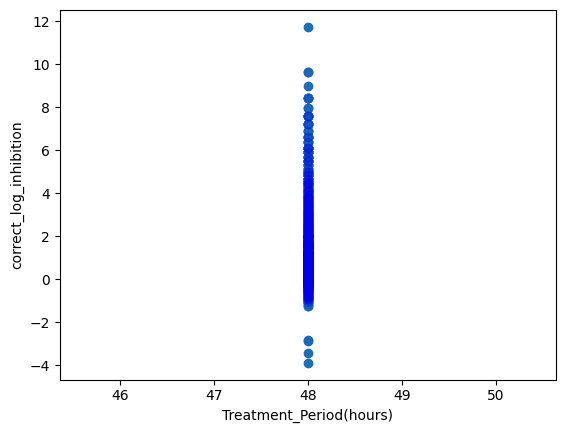

correct_log_inhibition
Feature:  exp_ps_hybr
P:0.14 p-value 4.1e-15
S:0.12 p-value 5.5e-12


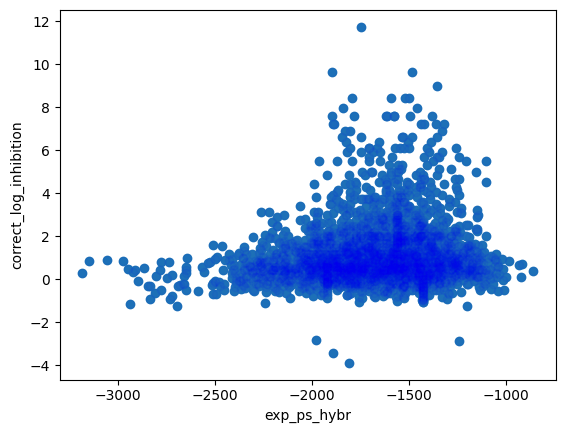

correct_log_inhibition
Feature:  at_rich_region_score
P:0.075 p-value 3.3e-05
S:0.067 p-value 0.0002


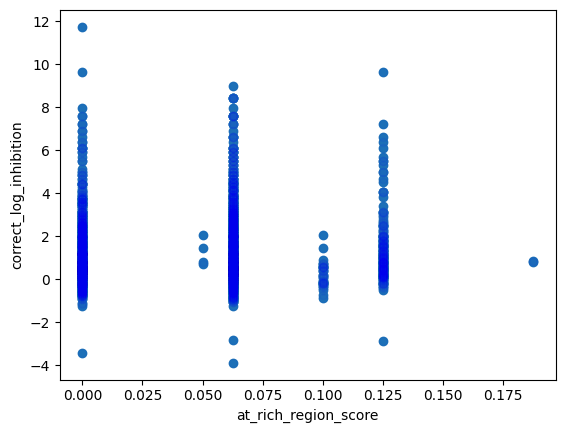

correct_log_inhibition
Feature:  at_skew
P:-0.29 p-value 2.6e-60
S:-0.28 p-value 3.2e-55


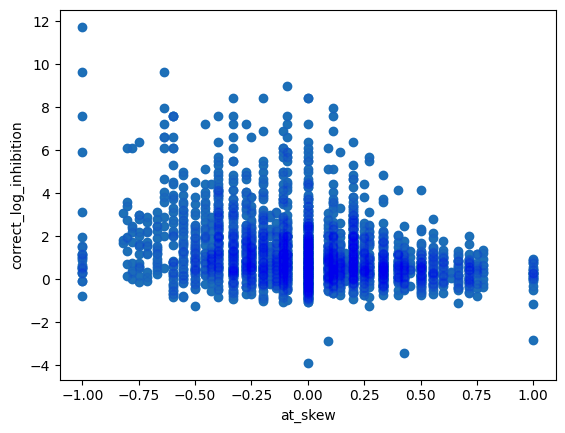

correct_log_inhibition
Feature:  entropy
P:0.013 p-value 0.49
S:0.025 p-value 0.17


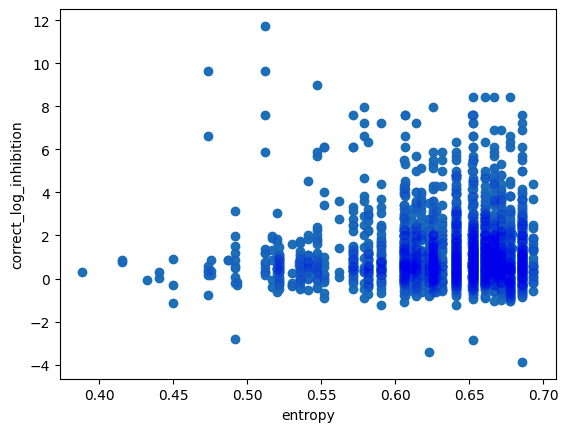

correct_log_inhibition
Feature:  gc_content
P:-0.2 p-value 4.1e-28
S:-0.19 p-value 1e-26


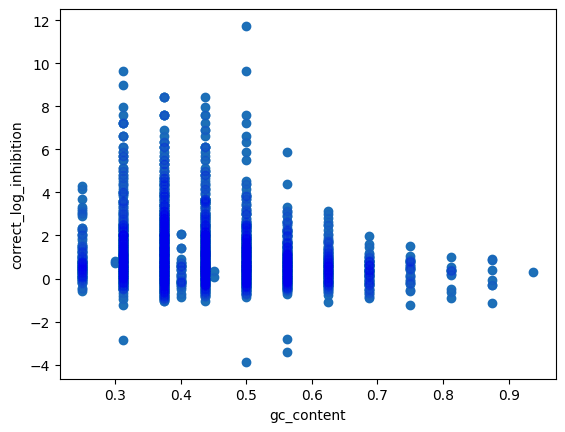

correct_log_inhibition
Feature:  gc_content_3_prime_5
P:-0.085 p-value 2.6e-06
S:-0.093 p-value 3e-07


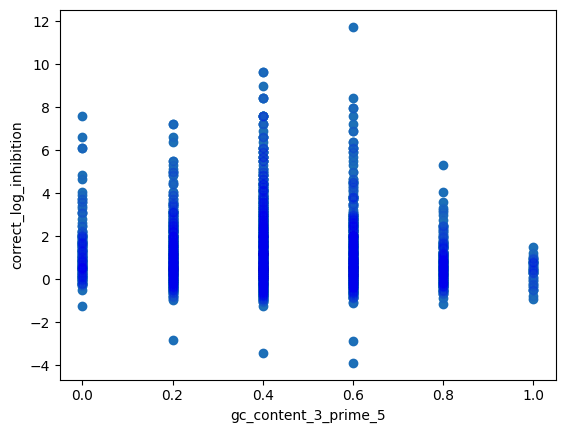

correct_log_inhibition
Feature:  gc_skew
P:0.11 p-value 4.4e-09
S:0.037 p-value 0.043


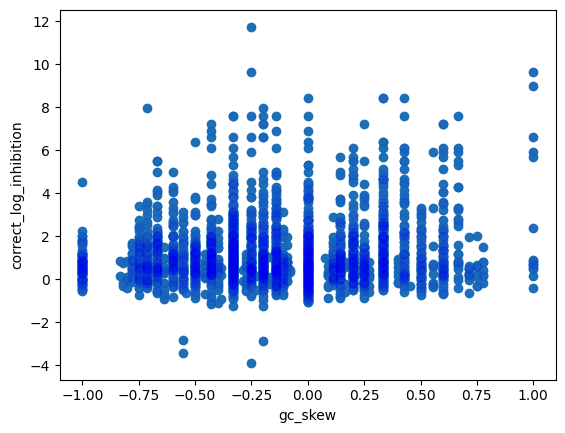

correct_log_inhibition
Feature:  hairpin_score
P:-0.093 p-value 2.5e-07
S:-0.11 p-value 1.4e-09


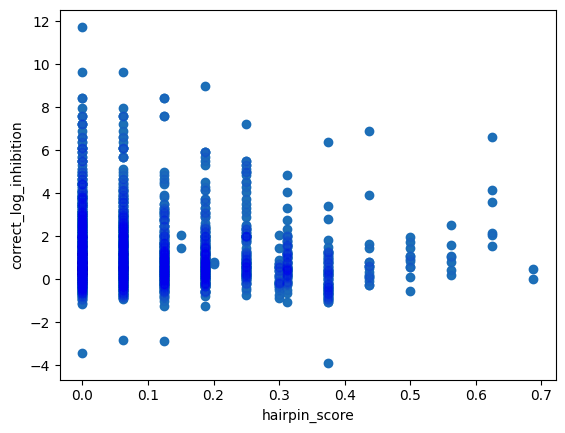

correct_log_inhibition
Feature:  homooligo_count
P:-0.069 p-value 0.00014
S:-0.075 p-value 3.3e-05


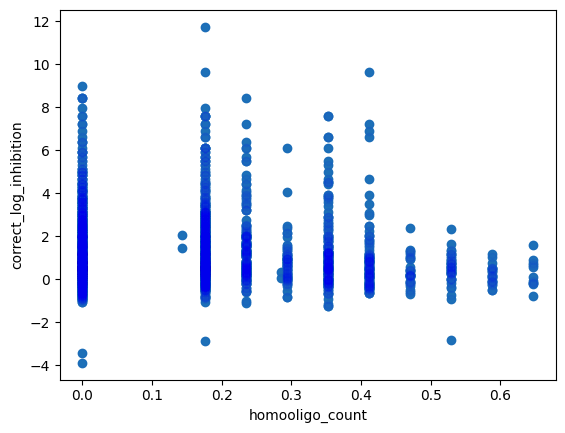

correct_log_inhibition
Feature:  internal_fold
P:0.17 p-value 2.1e-22
S:0.22 p-value 1.7e-33


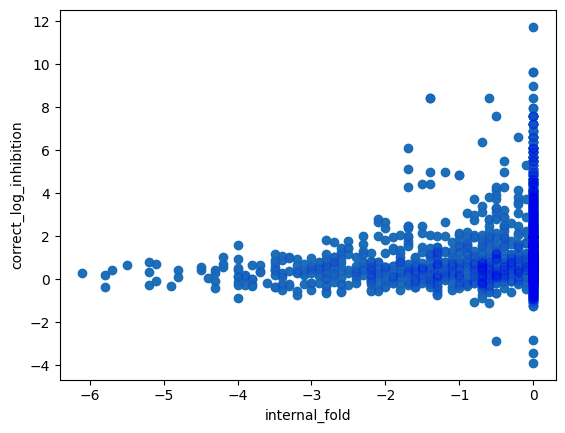

correct_log_inhibition
Feature:  normalized_start
P:0.12 p-value 3.6e-11
S:0.12 p-value 4.7e-12


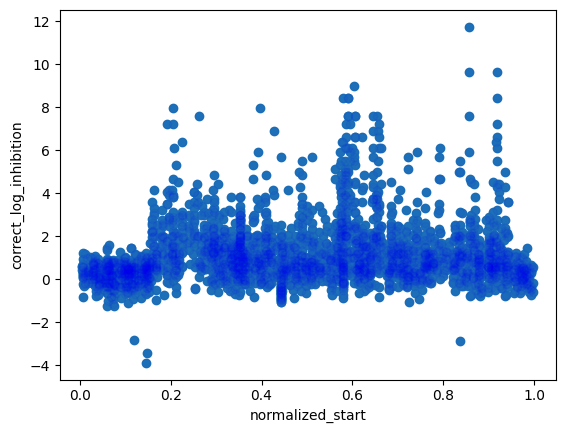

correct_log_inhibition
Feature:  nucleotide_diversity
P:0.084 p-value 3.5e-06
S:0.11 p-value 5.4e-10


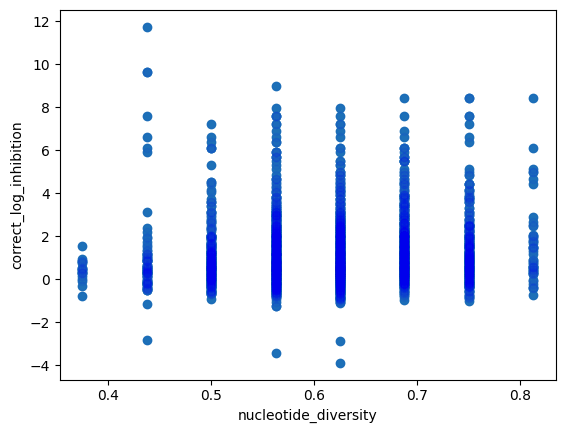

correct_log_inhibition
Feature:  poly_pyrimidine_stretch
P:0.15 p-value 4.7e-16
S:0.16 p-value 2.5e-18


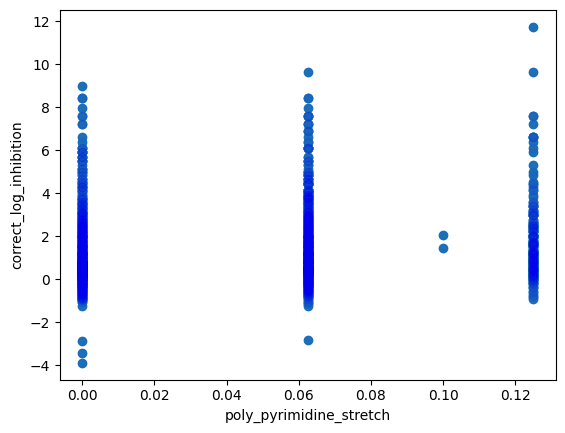

correct_log_inhibition
Feature:  self_energy
P:0.11 p-value 3.6e-09
S:0.1 p-value 1.1e-08


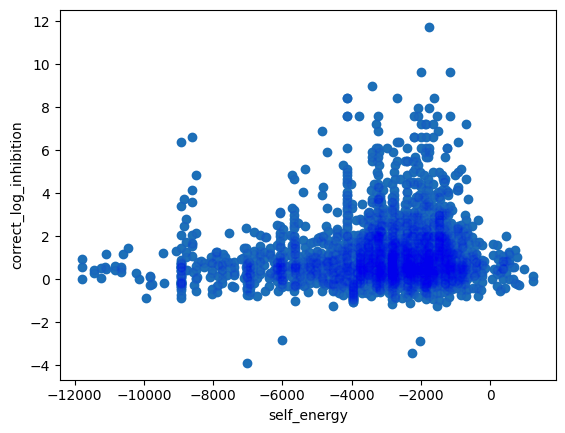

correct_log_inhibition
Feature:  stop_codon_count
P:0.1 p-value 8.3e-09
S:0.099 p-value 3.8e-08


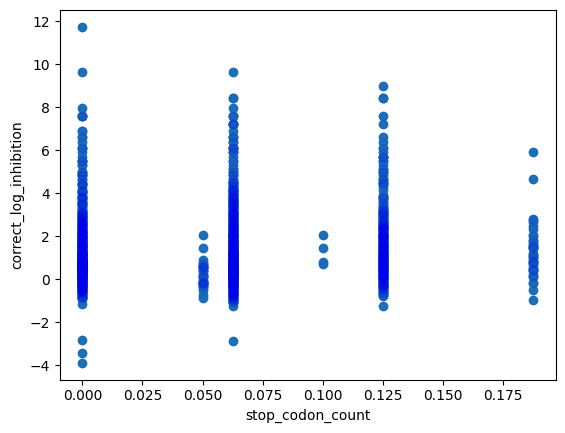

correct_log_inhibition
Feature:  sense_exon
P:0.2 p-value 8.1e-30
S:0.26 p-value 5.5e-49


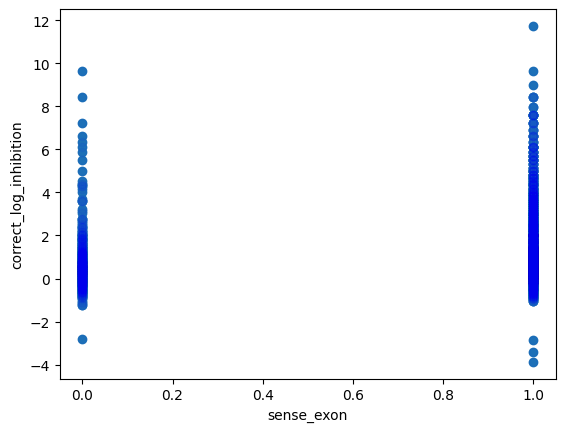

correct_log_inhibition
Feature:  sense_intron
P:-0.21 p-value 4.4e-31
S:-0.24 p-value 1.2e-40


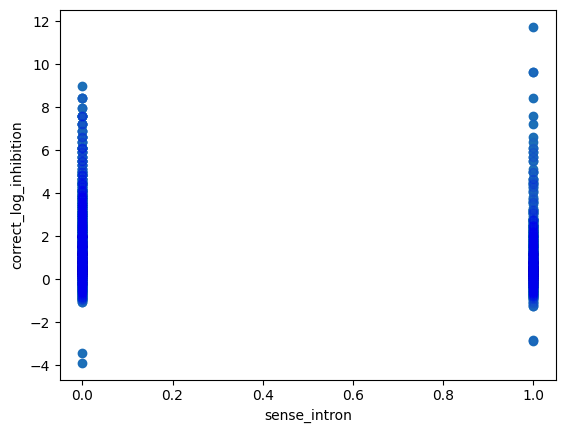

correct_log_inhibition
Feature:  sense_utr
P:nan p-value nan
S:nan p-value nan


/tmp/ipykernel_1720813/2315201020.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
/tmp/ipykernel_1720813/2315201020.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])


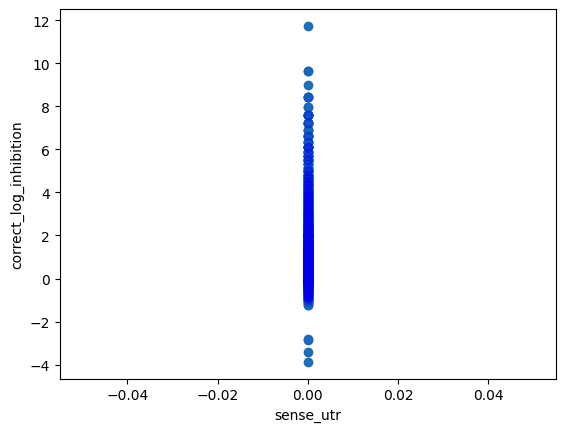

correct_log_inhibition
Feature:  on_target_fold_openness_normalized40_15
P:0.28 p-value 1.3e-57
S:0.29 p-value 8.7e-59


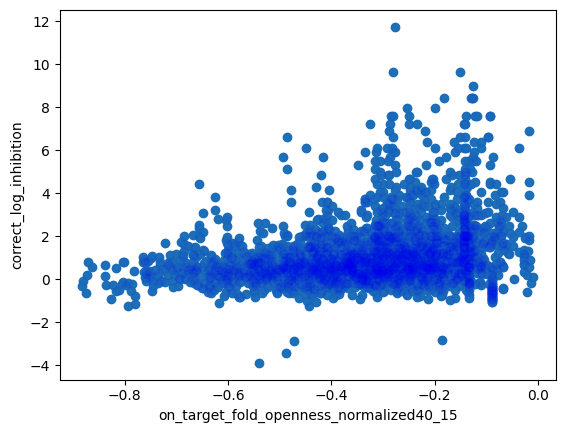

P:  0.5288215592023946
S:  0.4359761857930245
PTRAIN:  0.3549965662423411
PTEST:  0.357410873995882
STRAIN:  0.3425377555656915
STEST:  0.34171950094960524
PvaluePtest:  4.628991804898735e-91
PValueStest:  6.588334771568479e-83


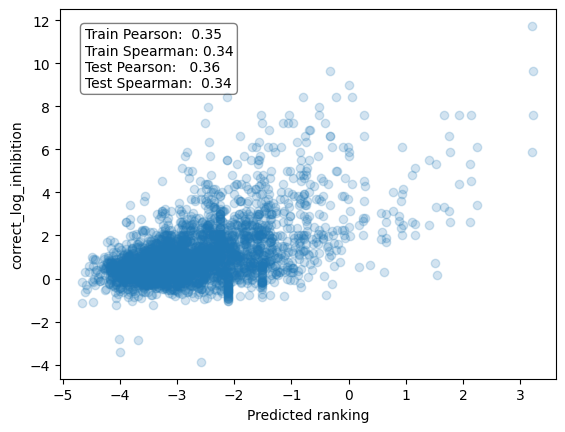

In [15]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    cell_line_mask = filtered[CELL_LINE] == cell_line
    print(f"cell-line:{cell_line}, length:{cell_line_mask.sum()} ", cell_line)
    print(metric)

    for gene in filtered[cell_line_mask][CANONICAL_GENE].unique():
        hepa_mask = cell_line_mask & (filtered[CANONICAL_GENE] == gene)
        print(f"gene-{gene} length: {hepa_mask.sum()}")
        # for f in ['sense_exon', 'sense_intron', 'sense_utr']:
        for f in ['NA']:
            # hep_pred = filtered[hepa_mask][f].to_numpy()
            # print(f"{f}: {filtered[hepa_mask][f].sum()} / {hepa_mask.sum()}")
            hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
            hepa_truth = filtered[hepa_mask][metric]
            p_hepa, pp_value = pearsonr(hepa_truth, hep_pred)
            s_hepa, sp_value = spearmanr(hepa_truth, hep_pred)
            print(f"P:{p_hepa:.2}, p-value: {pp_value:.2}")
            print(f"S:{s_hepa:.2} , p-value: {sp_value:.2}")

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CELL_LINE] == 'U251'

    # malat_mask = filtered[CANONICAL_GENE] == "HSD17B13"
    malat_mask = filtered[CANONICAL_GENE] == "MALAT1"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])

    plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='blue', alpha=0.05)
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print(f"P:{p_hepa:.2} p-value {pp_value:.2}")
    print(f"S:{s_hepa:.2} p-value {sp_value:.2}")
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, p_value_ptest = pearsonr(y_test, test_pred)
s_test, p_value_stest = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)
print("PvaluePtest: ", p_value_ptest)
print("PValueStest: ", p_value_stest)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel(metric)
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [16]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [17]:
def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

# def correction(df):
#     return (df[VOLUME]) / df[VOLUME]

def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)

for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

Threshold for top_1: 97.0
Threshold for top_5: 90.0
Threshold for top_10: 82.0
Threshold for top_50: 37.0


Mean model:  76.88888888888889
Mean best:  99.44444444444444
Mean random:  38.44444444444444


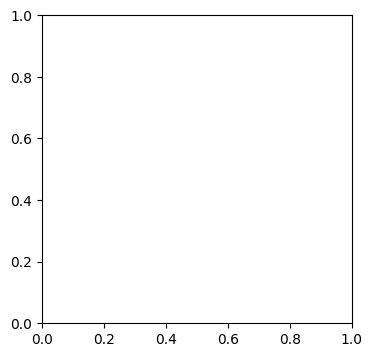

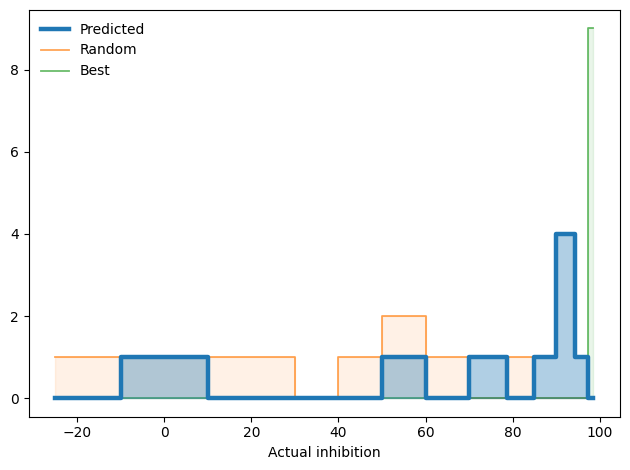

In [18]:
percentile = 0.5

train_threshold = get_threshold_for_percentile(percentile, train_pred)
test_threshold = get_threshold_for_percentile(percentile, test_pred)

test_mask = test_pred > test_threshold

top_k = test_mask.sum()

train_mask = train_pred > train_threshold

top_predicted_train = train_pred[train_mask]

top_train = log_inhibition_to_regular(y_train[train_mask] * correction(train_filtered[train_mask]))

top_predicted_test = test_pred[test_mask]
top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]))

# k already computed as the desired sample size
rand_mask = np.zeros(len(y_test), dtype=bool)
rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

# ---------- best possible ----------
all_inhib = log_inhibition_to_regular(y_test * correction(test_filtered))
top_best = all_inhib.nlargest(top_k).to_numpy()  # no index confusion

# random sample via mask
rand_perm = y_test[rand_mask]
top_rand_test = log_inhibition_to_regular(y_test[rand_mask] * correction(test_filtered[rand_mask]))

fig, ax = plt.subplots(figsize=(4, 4))
# ax.boxplot([top_test, top_rand_test],
#            tick_labels=['Top‑predicted', 'Random baseline']
#            )
print("Mean model: ", np.mean(top_test))
print("Mean best: ", np.mean(top_best))
print("Mean random: ", np.mean(top_rand_test))

# print("Mean model: ", geo_mean_overflow(top_test))
# print("Mean best: ", geo_mean_overflow(top_best))
# print("Mean random: ", geo_mean_overflow(top_rand_test))
bins = np.array([-50, 0, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 97, 100])
x = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots()

# --- Predicted: thick line, darker fill ---------------------------------
h_pred, _ = np.histogram(top_test, bins=bins)
ax.plot(x, h_pred, drawstyle='steps-mid', lw=3.2, color='C0',
        label='Predicted', zorder=5)
ax.fill_between(x, 0, h_pred, step='mid', alpha=0.35, color='C0', zorder=4)

# --- Others: thinner, lighter -------------------------------------------
for arr, lab, c in [(top_rand_test, 'Random', 'C1'),
                    (top_best, 'Best', 'C2')]:
    h, _ = np.histogram(arr, bins=bins)
    ax.plot(x, h, drawstyle='steps-mid', lw=1.3, color=c, alpha=0.7, label=lab, zorder=3)
    ax.fill_between(x, 0, h, step='mid', alpha=0.10, color=c, zorder=2)

# ax.set_yscale('log')        # drop if you don't want log
ax.set_xlabel('Actual inhibition')
ax.legend(frameon=False)
fig.tight_layout()
plt.show()



In [19]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

[-4.655047  -4.6532564 -4.614667  ...  3.2085698  3.229329   3.229329 ]


0.9481507

In [20]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric = "correct_log_inhibition"  # target column
groups = filtered[CELL_LINE]  # one “qid” per row
gkf = GroupKFold(n_splits=6)


def spearman_scorer(est, X, y):  # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2


all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)  # keep queries contiguous
    test_df = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features], test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist()  # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
        ranker, X_te.to_numpy(), y_te.to_numpy(),
        n_repeats=30, scoring=spearman_scorer,
        random_state=42, n_jobs=1
    )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)  # (folds × features)
imp_df = pd.DataFrame(
    imp_mat.T,
    index=features,
    columns=[f"fold_{i + 1}" for i in range(imp_mat.shape[0])]
)

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))


In [21]:
print(summary.head(15))


                                         mean_imp   std_imp
on_target_fold_openness_normalized40_15  0.035834  0.054877
at_skew                                  0.026528  0.023494
gc_content                               0.016774  0.017154
stop_codon_count                         0.010380  0.015180
exp_ps_hybr                              0.009075  0.015467
internal_fold                            0.007320  0.005167
Treatment_Period(hours)                  0.007145  0.012450
at_rich_region_score                     0.006279  0.014339
entropy                                  0.005558  0.013245
sense_exon                               0.003720  0.010956
gc_skew                                  0.003529  0.016087
hairpin_score                            0.002419  0.002702
gc_content_3_prime_5                     0.001777  0.007806
nucleotide_diversity                     0.000197  0.003115
homooligo_count                         -0.000980  0.002015


In [22]:
SL_PARTNERS = ['RIOK1', 'PRMT5', 'MAT2A']
SEQUENCES = {}
for partner in SL_PARTNERS:
    SEQUENCES[partner] = gene_to_data[partner].full_mrna
RIOK1 = gene_to_data['RIOK1'].full_mrna
PRMT5 = gene_to_data['PRMT5'].full_mrna
MAT2A = gene_to_data['MAT2A'].full_mrna

In [23]:
from asodesigner.util import get_antisense
import pandas as pd

def get_init_df(target_mrna, end):
    candidates = []
    sense_starts = []
    sense_lengths = []
    sense_starts_from_end = []

    for i in range(0, len(target_mrna) - 19):
        target = target_mrna[i: i + 20]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(20)
        sense_starts_from_end.append(end - i)
    df = pd.DataFrame(
        {SEQUENCE: candidates, SENSE_START: sense_starts,
         SENSE_LENGTH: sense_lengths, "sense_start_from_end": sense_starts_from_end})
    return df

dfs = {}
for partner in SL_PARTNERS:
    gene_info = gene_to_data[partner]
    dfs[partner] = get_init_df(gene_info.full_mrna, gene_info.exon_indices[-1][1] - gene_info.cds_start)

In [24]:
for gene, df in dfs.items():
    df[CANONICAL_GENE] = gene

In [25]:
for df in dfs.values():
    df[CELL_LINE_ORGANISM] = 'human'
    df[INHIBITION] = 0 # Just for the function, not important

In [26]:
for gene, df in dfs.items():
    df = get_populated_df_with_structure_features(df, SL_PARTNERS, gene_to_data)
    dfs[gene] = df

In [27]:
from scripts.data_genertion.data_handling import populate_features

for gene, df in dfs.items():
    df[TREATMENT_PERIOD] = 24  # keep constant for all
    df[VOLUME] = 1000  # keep constant for all
    df['log_volume'] = np.log(df[VOLUME])
    df['normalized_start'] = df[SENSE_START] / len(SEQUENCES[gene])
    df['normalized_sense_start_from_end'] = df['sense_start_from_end'] / len(SEQUENCES[gene])
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score',
                        'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy', 'stop_codon_count',
                        'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)


In [28]:
for gene, df in dfs.items():
    fold_variants = [(40, 15)]
    df = get_populate_fold(df, SL_PARTNERS, gene_to_data, fold_variants=fold_variants)
    dfs[gene] = df

In [29]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for gene, df in dfs.items():
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]
    print(df.columns)

Index(['Sequence', 'sense_start', 'sense_length', 'sense_start_from_end',
       'Canonical Gene Name', 'Cell line organism', 'Inhibition(%)',
       'sense_exon', 'sense_intron', 'sense_utr', 'sense_type',
       'Treatment_Period(hours)', 'ASO_volume(nM)', 'log_volume',
       'normalized_start', 'normalized_sense_start_from_end', 'self_energy',
       'internal_fold', 'gc_content', 'gc_content_3_prime_5',
       'homooligo_count', 'entropy', 'hairpin_score', 'gc_skew', 'at_skew',
       'nucleotide_diversity', 'stop_codon_count', 'at_rich_region_score',
       'poly_pyrimidine_stretch', 'on_target_fold_openness40_15',
       'on_target_fold_openness_normalized40_15', 'exp_ps_hybr'],
      dtype='object')
Index(['Sequence', 'sense_start', 'sense_length', 'sense_start_from_end',
       'Canonical Gene Name', 'Cell line organism', 'Inhibition(%)',
       'sense_exon', 'sense_intron', 'sense_utr', 'sense_type',
       'Treatment_Period(hours)', 'ASO_volume(nM)', 'log_volume',
       'no

In [30]:
scores_per_gene = {}
for gene, df in dfs.items():
    scores_per_gene[gene] = model.predict(df[features])

In [34]:
for gene in SL_PARTNERS:
    scores = scores_per_gene[gene]
    print(f"Num scores for {gene}: {len(scores)}")
    k = 400  # how many top rows
    idx = np.argsort(-scores)[:k]
    # print(df.iloc[idx])
    # (optional) with scores:
    df_with_scores = dfs[gene].assign(score=scores)
    df_with_scores.iloc[idx].to_csv(f'{gene}_asos.csv', index=False)

Num scores for RIOK1: 28226
Num scores for PRMT5: 8865
Num scores for MAT2A: 6095


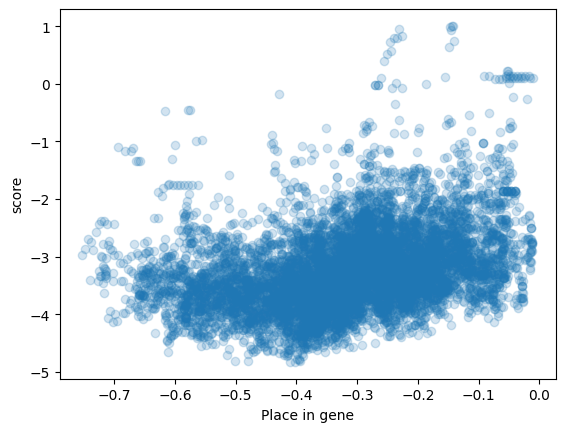

Feature: on_target_fold_openness_normalized40_15, Pearson: 0.35 , p-value: 2.9e-255   Target: score                              
Feature: on_target_fold_openness_normalized40_15, Spearman: 0.40 , p-value: 0.0        Target: score                              
Feature: on_target_fold_openness_normalized40_15, MIC:      0.21                              Target: score                              


In [32]:
gene = 'PRMT5'
df_with_scores = dfs[gene].assign(score=scores_per_gene[gene])
df_with_scores['relative_score'] = 1 - df_with_scores['score'].rank(method='max', pct=True)

from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression

metric = 'correct_log_inhibition'


def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")


# for gene in genes_u:
# print("gene, ", gene)
feature = 'on_target_fold_openness_normalized40_15'
# feature = 'exp_ps_hybr'
current_df = df_with_scores
current_df = df_with_scores[df_with_scores[CANONICAL_GENE] == gene]
plt.scatter(current_df[feature], current_df['score'], alpha=0.2)
plt.xlabel('Place in gene')
plt.ylabel(f'score')
plt.show()

print_correlations(current_df, feature, 'score')
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', metric)
# print_correlations(current_df, 'on_target_fold_openness_normalized40_15', 'score')